# Exploratory Data Analysis (Raw Dataset)
**Project objective:** Predict heart-related health risks, explain individual predictions with LIME/SHAP, and deliver both via a clinician-friendly Gradio demo backed by a Dockerised pipeline. This notebook inspects the raw input data (`data/raw/heart_data.csv`) to quantify quality issues, class balance, and feature distributions before preprocessing.


## Setup

In [2]:

from pathlib import Path
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')

DATA_PATH = Path('../data/raw/heart_data.csv')
PLOTS_DIR = Path('../results/plots')
METRICS_DIR = Path('../results/metrics')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
TARGET_COLUMN = 'hltprhc'

print(f'Using raw dataset: {DATA_PATH.resolve()}')


Using raw dataset: /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/data/raw/heart_data.csv


### Feature Reference
For quick reference during EDA, the preprocessing script exposes the following constants (see `src/data_preprocessing.py`):

```python
FEATURE_MAP_PATH = PROCESSED_DIR / "feature_names.csv"
FEATURE_ABBREVIATIONS = {
    "hltprhc": "Heart condition",
    "hltprhb": "Blood pressure",
    "hltprdi": "Diabetes",
}

FEATURE_DESCRIPTIONS = {
    "cntry": "Country code of respondent (ISO-2).",
    "happy": "Self-rated happiness on a 0–10 scale.",
    "sclmeet": "Frequency of social meetings with friends, relatives, or colleagues.",
    "inprdsc": "Frequency of participation in organised social, religious, or community activities.",
    "health": "Self-rated general health (1 very good to 5 very bad).",
    "ctrlife": "Feeling of control over life (0 no control to 10 complete control).",
    "etfruit": "Frequency of fruit consumption.",
    "eatveg": "Frequency of vegetable consumption.",
    "dosprt": "Frequency of doing sports or physical exercise.",
    "cgtsmok": "Cigarette smoking status or frequency.",
    "alcfreq": "Alcohol consumption frequency.",
    "height": "Self-reported height in centimeters.",
    "weighta": "Self-reported weight in kilograms.",
    "fltdpr": "How often felt depressed in the last week.",
    "flteeff": "How often felt everything was an effort in the last week.",
    "slprl": "How often sleep was restless in the last week.",
    "wrhpp": "How often felt happy in the last week (reverse coded).",
    "fltlnl": "How often felt lonely in the last week.",
    "enjlf": "How often enjoyed life in the last week (reverse coded).",
    "fltsd": "How often felt sad in the last week.",
    "hltprhc": "Doctor diagnosed heart or circulation problems (1 yes 0 no).",
    "hltprhb": "Doctor diagnosed high blood pressure (1 yes 0 no).",
    "hltprdi": "Doctor diagnosed diabetes (1 yes 0 no).",
    "gndr": "Gender of respondent (1 male 2 female).",
    "paccnois": "Perceived noise problems in the local area (1 yes 0 no).",
}
```

Use `data/processed/feature_names.csv` for the complete mapping once preprocessing has been run.


### Load Dataset

In [3]:

df = pd.read_csv(DATA_PATH, na_values=['NA', ''])
# Drop unnamed index column if present
first_col = df.columns[0]
if first_col.strip() == '' or first_col.lower().startswith('unnamed'):
    df = df.drop(columns=[first_col])

# Standardise column whitespace
df.columns = df.columns.str.strip()

# Convert non-categorical columns to numeric (coerce invalid entries to NaN)
numeric_candidate_cols = [col for col in df.columns if col != 'cntry']
for column in numeric_candidate_cols:
    df[column] = pd.to_numeric(df[column], errors='coerce')

row_count, col_count = df.shape
print(f'Rows: {row_count} | Columns: {col_count}')
df.head()


Rows: 42377 | Columns: 25


,cntry,happy,sclmeet,inprdsc,health,ctrlife,etfruit,eatveg,dosprt,cgtsmok,...,slprl,wrhpp,fltlnl,enjlf,fltsd,hltprhc,hltprhb,hltprdi,gndr,paccnois
0,AT,8.0,4.0,1.0,3.0,8.0,3.0,3.0,3.0,4.0,...,1.0,3.0,1.0,3.0,1.0,0,1,0,1,0
1,AT,9.0,7.0,4.0,2.0,8.0,1.0,1.0,5.0,5.0,...,3.0,3.0,3.0,4.0,2.0,1,0,0,2,0
2,AT,9.0,4.0,4.0,1.0,9.0,4.0,3.0,3.0,1.0,...,3.0,3.0,1.0,3.0,1.0,0,0,0,2,0
3,AT,7.0,6.0,3.0,3.0,8.0,2.0,2.0,3.0,6.0,...,3.0,2.0,2.0,2.0,2.0,0,1,1,2,0
4,AT,9.0,5.0,4.0,2.0,9.0,3.0,3.0,3.0,1.0,...,1.0,3.0,1.0,3.0,1.0,0,0,0,1,0


### Dataset Overview

In [4]:

buffer = io.StringIO()
df.info(buf=buffer)
info_text = buffer.getvalue()
print(info_text)

numeric_desc = df.describe().T
display(numeric_desc)

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    categorical_desc = df[categorical_cols].describe().T
    display(categorical_desc)
else:
    print('No categorical columns detected.')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42377 entries, 0 to 42376
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cntry     42377 non-null  object 
 1   happy     42260 non-null  float64
 2   sclmeet   42306 non-null  float64
 3   inprdsc   42169 non-null  float64
 4   health    42339 non-null  float64
 5   ctrlife   42205 non-null  float64
 6   etfruit   42284 non-null  float64
 7   eatveg    42282 non-null  float64
 8   dosprt    41926 non-null  float64
 9   cgtsmok   42305 non-null  float64
 10  alcfreq   42180 non-null  float64
 11  height    42377 non-null  int64  
 12  weighta   42377 non-null  int64  
 13  fltdpr    42224 non-null  float64
 14  flteeff   42231 non-null  float64
 15  slprl     42264 non-null  float64
 16  wrhpp     42144 non-null  float64
 17  fltlnl    42209 non-null  float64
 18  enjlf     42116 non-null  float64
 19  fltsd     42208 non-null  float64
 20  hltprhc   42377 non-null  in

,count,mean,std,min,25%,50%,75%,max
happy,42260.0,7.394628,1.838132,0.0,7.0,8.0,9.0,10.0
sclmeet,42306.0,4.786082,1.580821,1.0,4.0,5.0,6.0,7.0
inprdsc,42169.0,2.720434,1.425431,0.0,2.0,3.0,4.0,6.0
health,42339.0,2.144666,0.905196,1.0,1.0,2.0,3.0,5.0
ctrlife,42205.0,7.373581,2.024204,0.0,6.0,8.0,9.0,10.0
etfruit,42284.0,3.220864,1.310744,1.0,2.0,3.0,4.0,7.0
eatveg,42282.0,3.155267,1.112567,1.0,2.0,3.0,4.0,7.0
dosprt,41926.0,3.158374,2.598722,0.0,0.0,3.0,5.0,7.0
cgtsmok,42305.0,4.346791,1.833068,1.0,3.0,5.0,6.0,6.0
alcfreq,42180.0,4.635396,2.048302,1.0,3.0,5.0,7.0,7.0


,count,unique,top,freq
cntry,42377,28,GR,2612


### Checking Missing Values

In [19]:

missing_counts = df.isna().sum().sort_values(ascending=False)
missing_df = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_pct': (missing_counts / row_count * 100).round(2)
})
display(missing_df)
missing_df.to_csv(METRICS_DIR / 'missing_values_summary.csv')


,missing_count,missing_pct
dosprt,451,1.06
enjlf,261,0.62
wrhpp,233,0.55
inprdsc,208,0.49
alcfreq,197,0.46
ctrlife,172,0.41
fltsd,169,0.40
fltlnl,168,0.40
fltdpr,153,0.36
flteeff,146,0.34


### Missing Value Heatmap

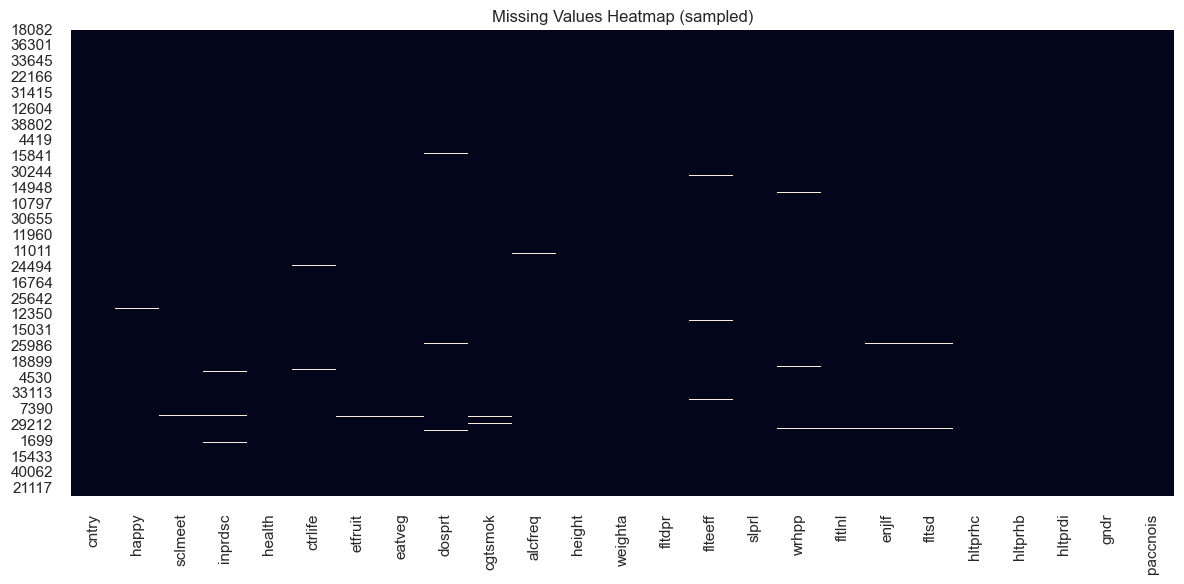

In [20]:

sample_size = min(1000, len(df))
subset = df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df.copy()
plt.figure(figsize=(12, 6))
sns.heatmap(subset.isna(), cbar=False)
plt.title('Missing Values Heatmap (sampled)' if len(df) > sample_size else 'Missing Values Heatmap')
heatmap_path = PLOTS_DIR / 'missing_values_heatmap.png'
plt.tight_layout()
plt.savefig(heatmap_path)
plt.show()


### Target Distribution (hltprhc)

,count,percentage
hltprhc,,
0,37582,88.68
1,4795,11.32


/var/folders/n7/xdcht4j57pb8lxj2cl5f_c500000gn/T/ipykernel_34628/1455190147.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_balance_df.index.astype(str), y='count', data=class_balance_df.reset_index(drop=True), palette='pastel')


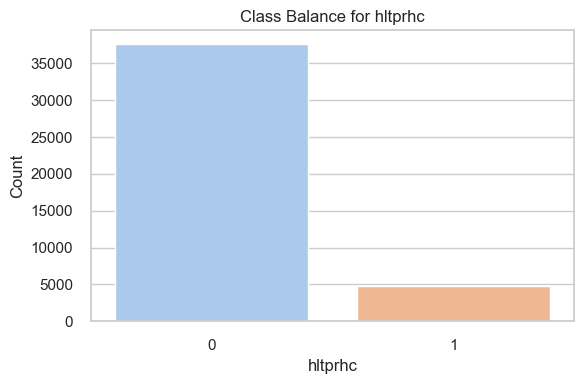

In [21]:

target_counts = df[TARGET_COLUMN].value_counts().sort_index()
target_pct = (target_counts / row_count * 100).round(2)
class_balance_df = pd.DataFrame({'count': target_counts, 'percentage': target_pct})
display(class_balance_df)
plt.figure(figsize=(6, 4))
sns.barplot(x=class_balance_df.index.astype(str), y='count', data=class_balance_df.reset_index(drop=True), palette='pastel')
plt.title('Class Balance for hltprhc')
plt.xlabel('hltprhc')
plt.ylabel('Count')
plt.tight_layout()
class_balance_path = PLOTS_DIR / 'class_balance.png'
plt.savefig(class_balance_path)
plt.show()


### Numeric Variable Distributions

Numeric features (23): ['happy', 'sclmeet', 'inprdsc', 'health', 'ctrlife', 'etfruit', 'eatveg', 'dosprt', 'cgtsmok', 'alcfreq', 'height', 'weighta', 'fltdpr', 'flteeff', 'slprl', 'wrhpp', 'fltlnl', 'enjlf', 'fltsd', 'hltprhb', 'hltprdi', 'gndr', 'paccnois']


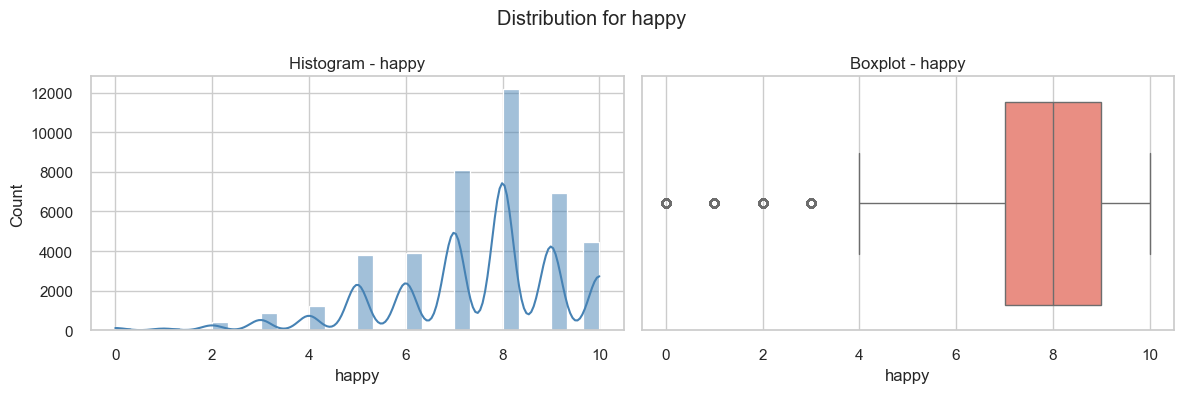

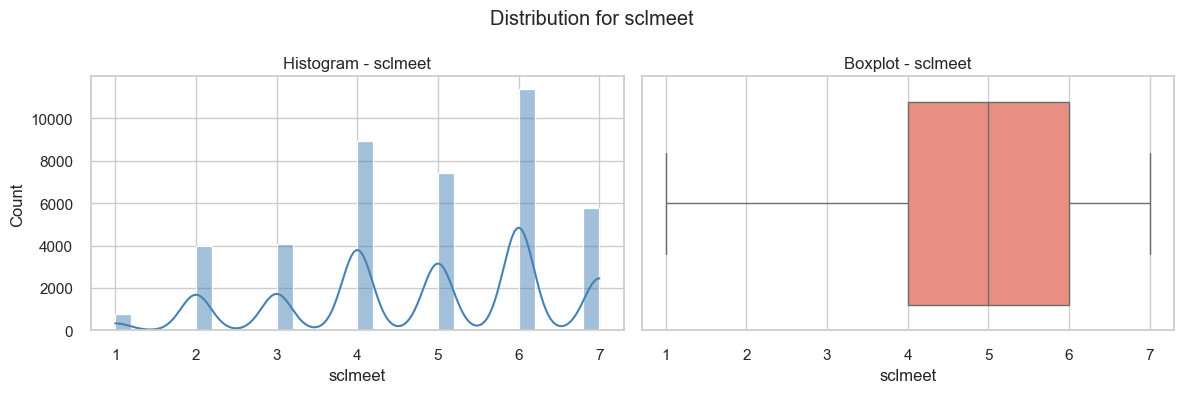

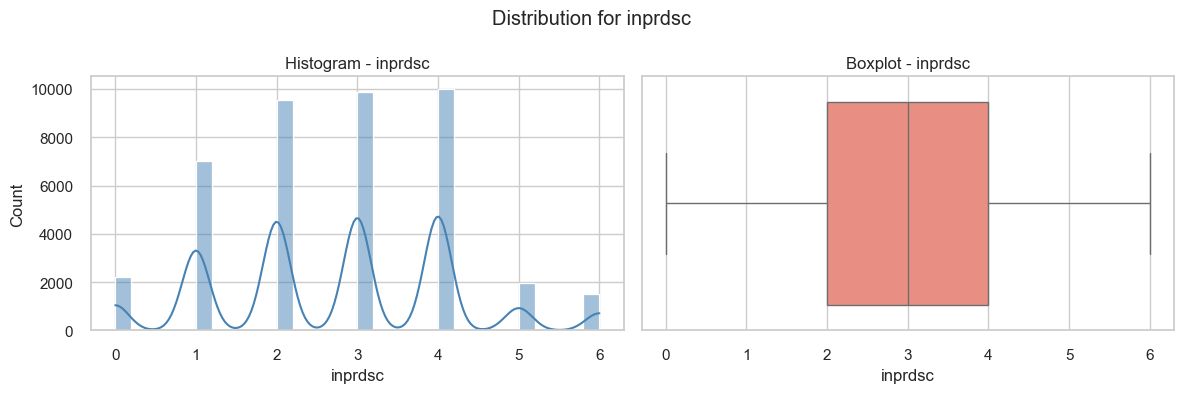

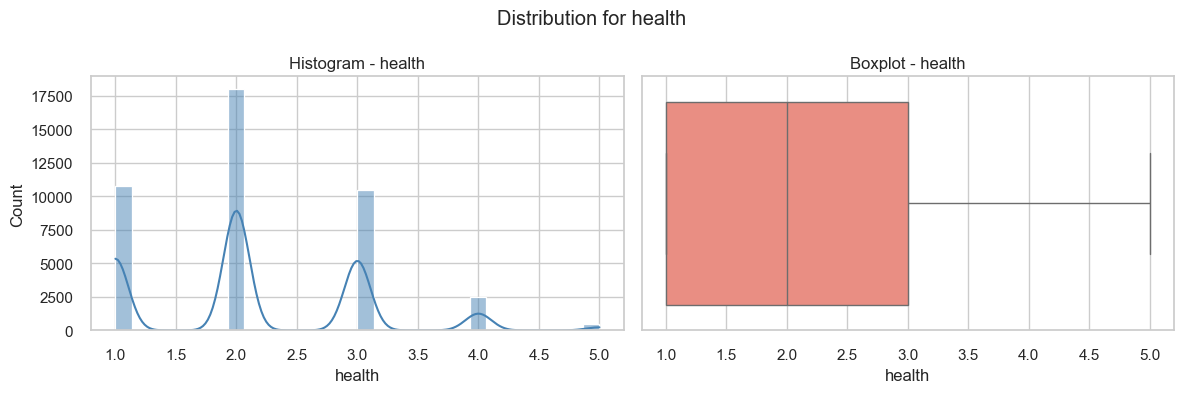

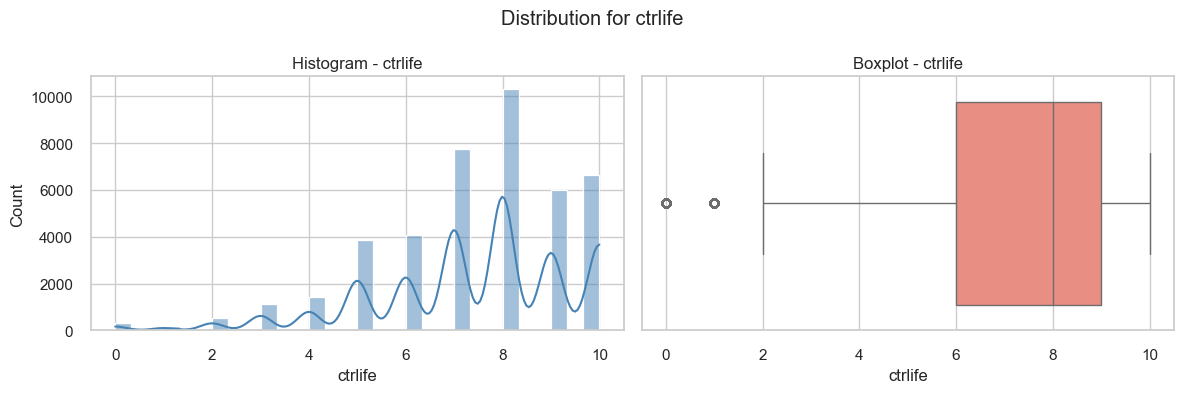

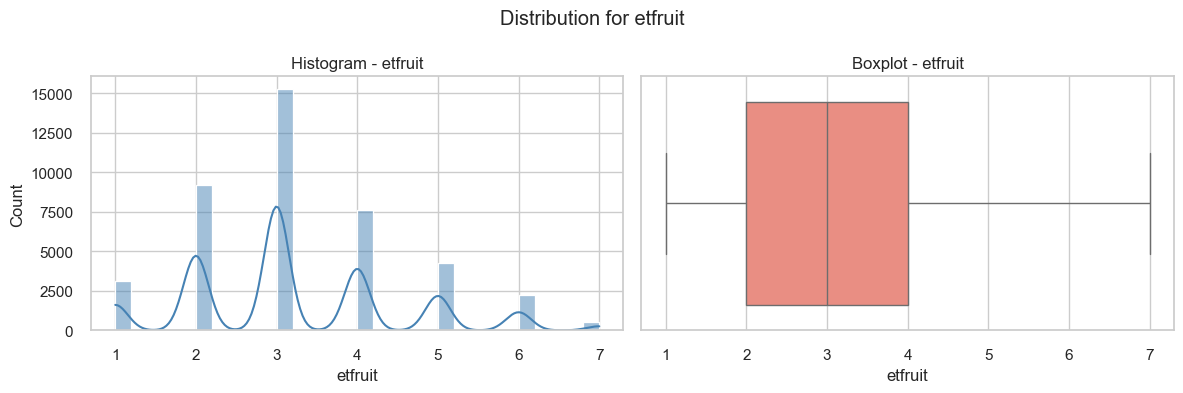

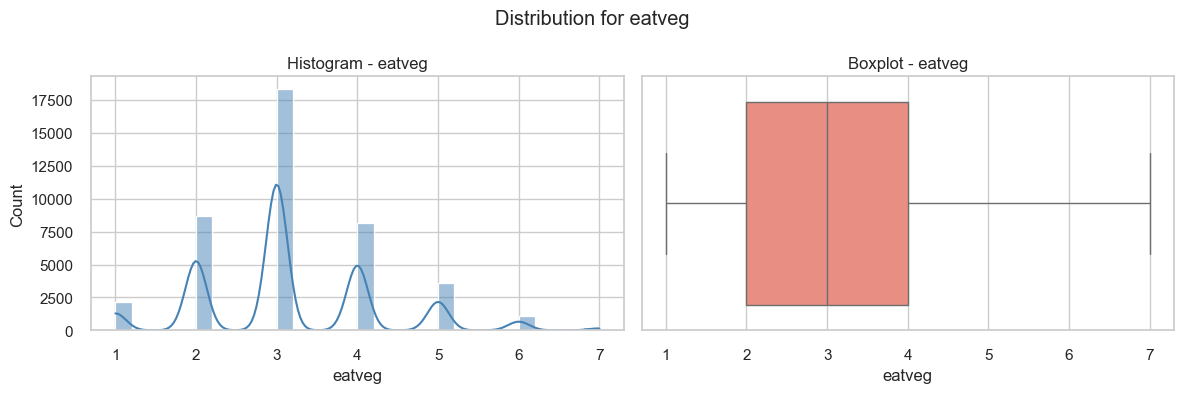

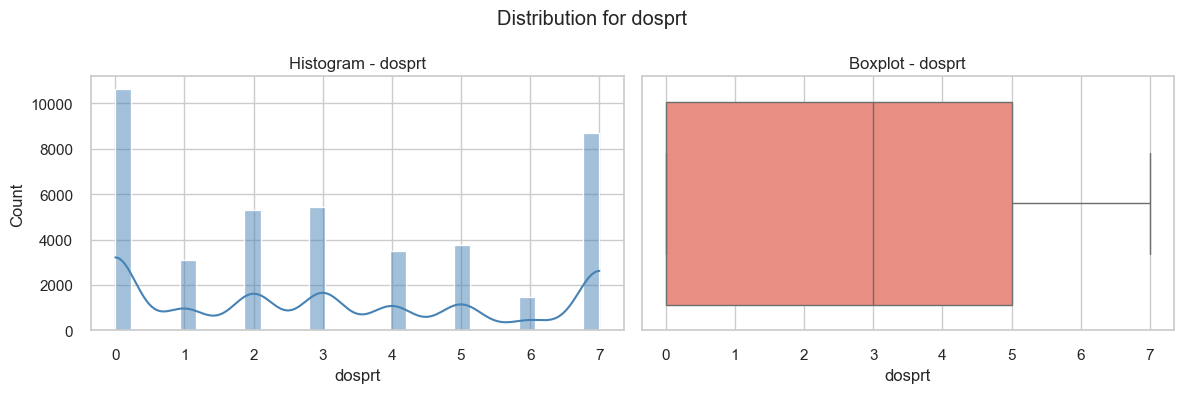

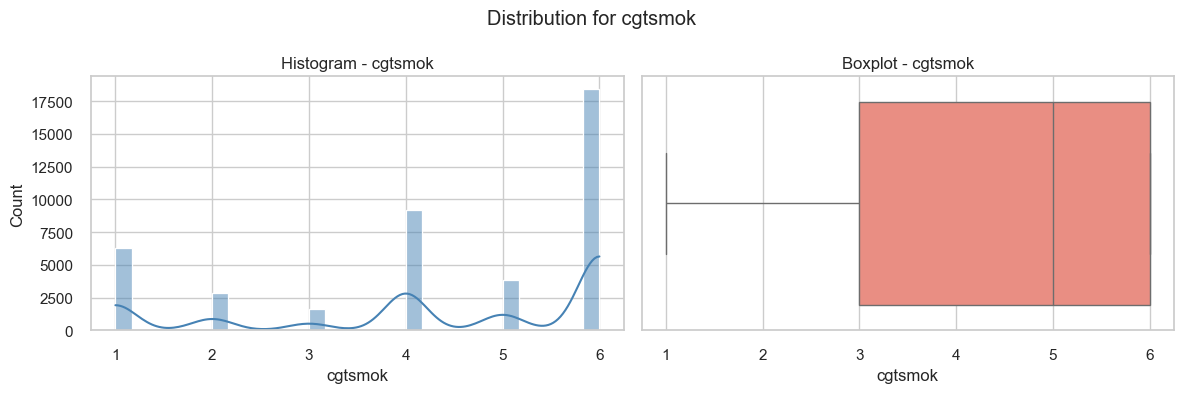

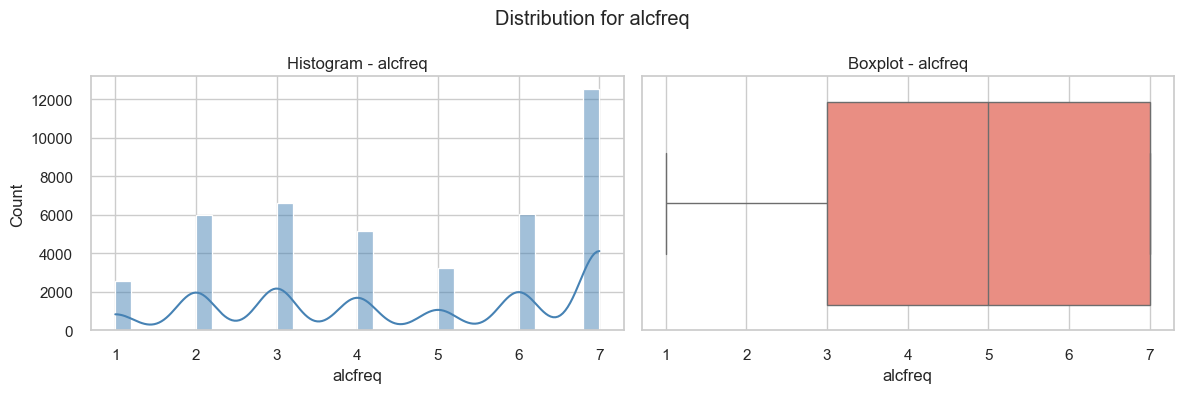

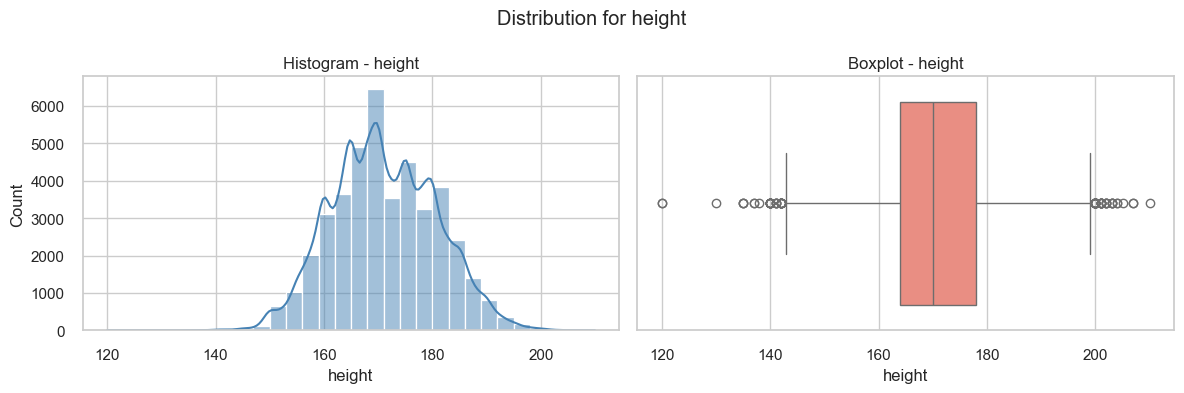

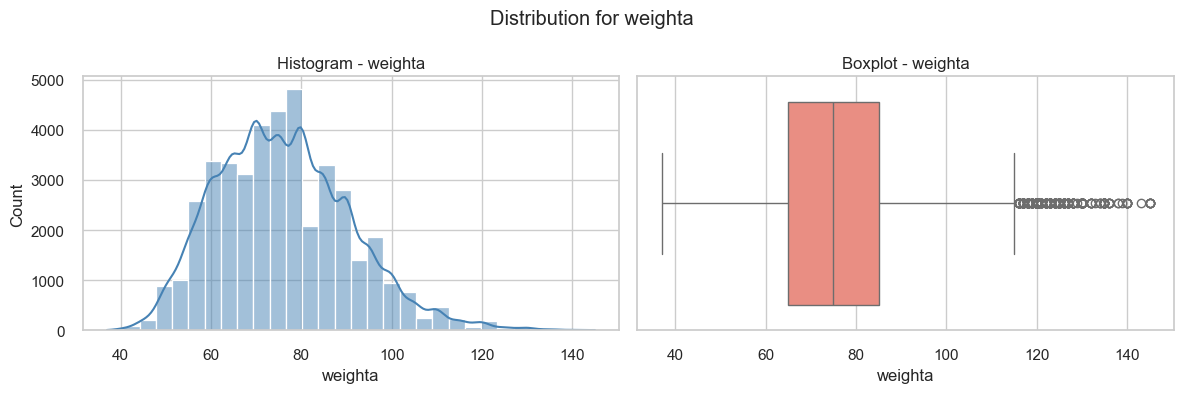

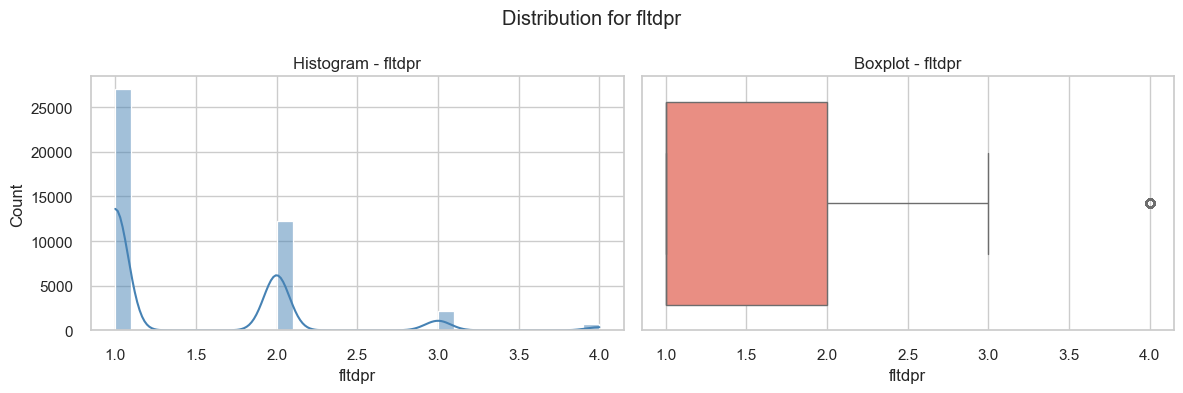

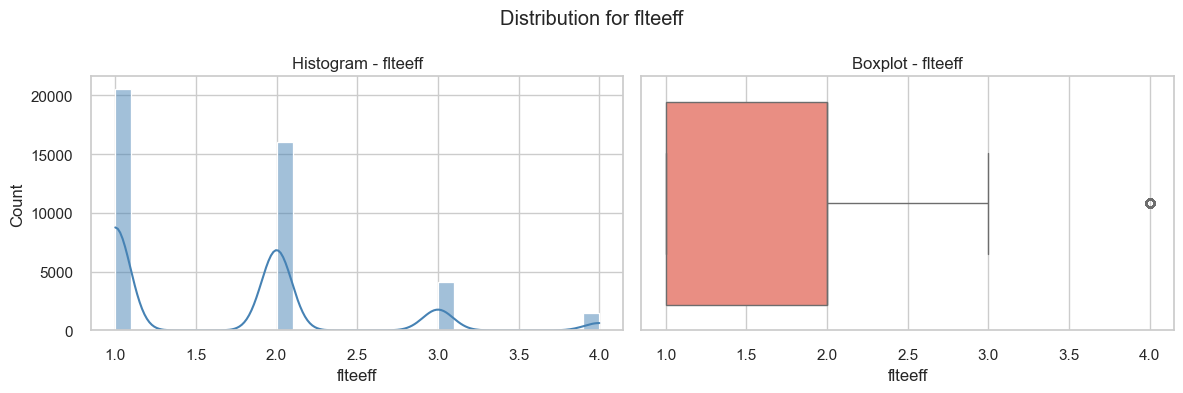

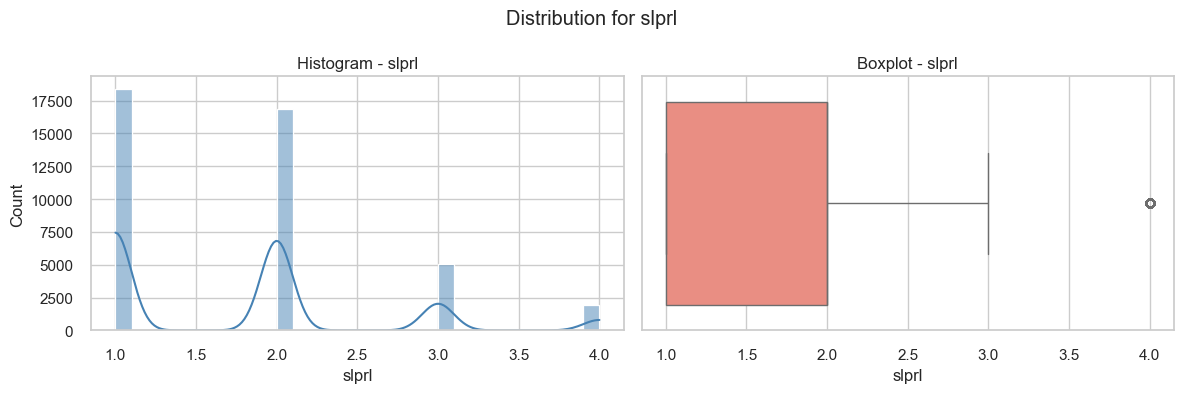

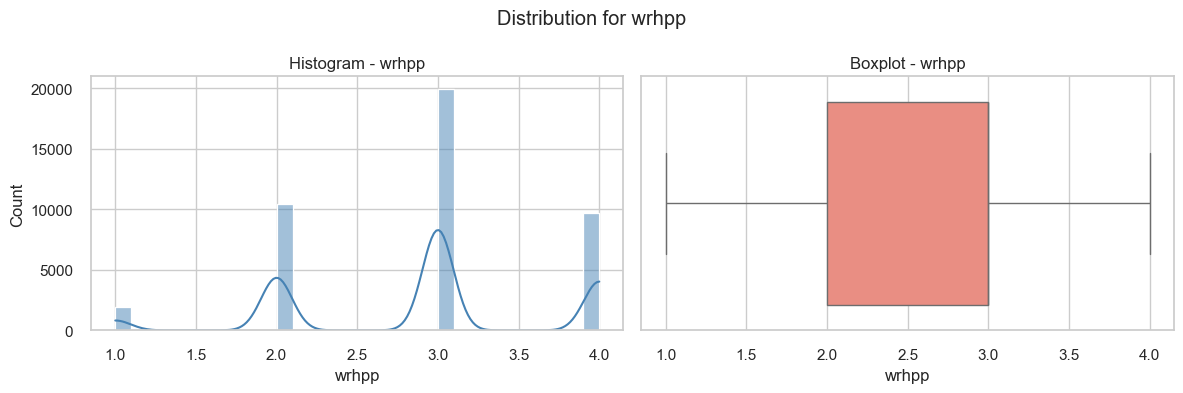

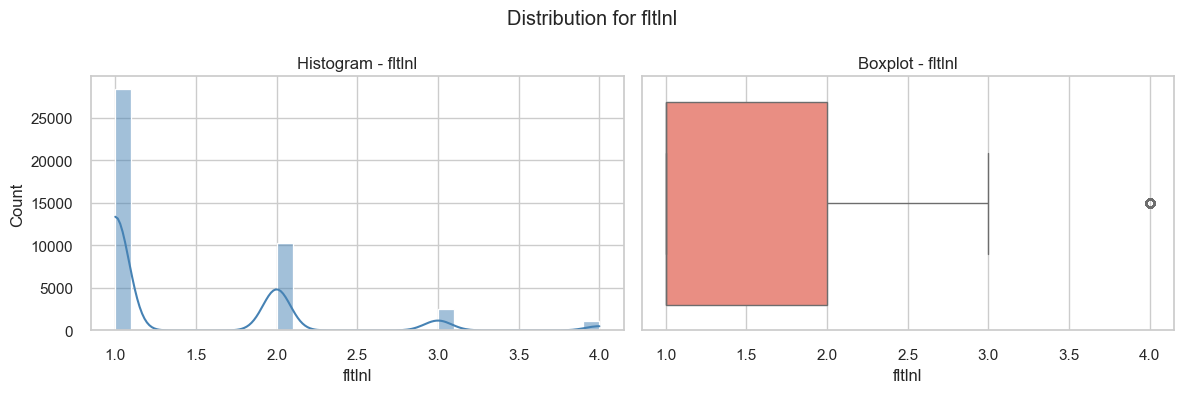

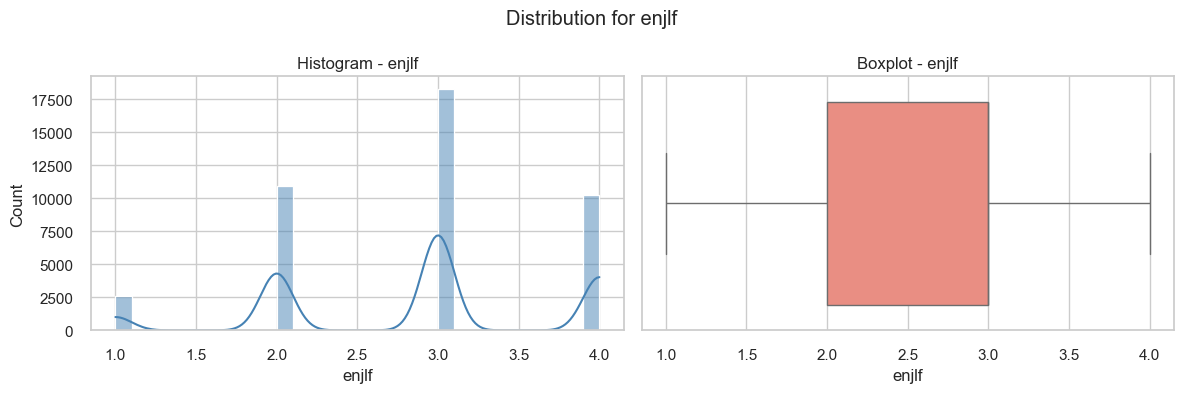

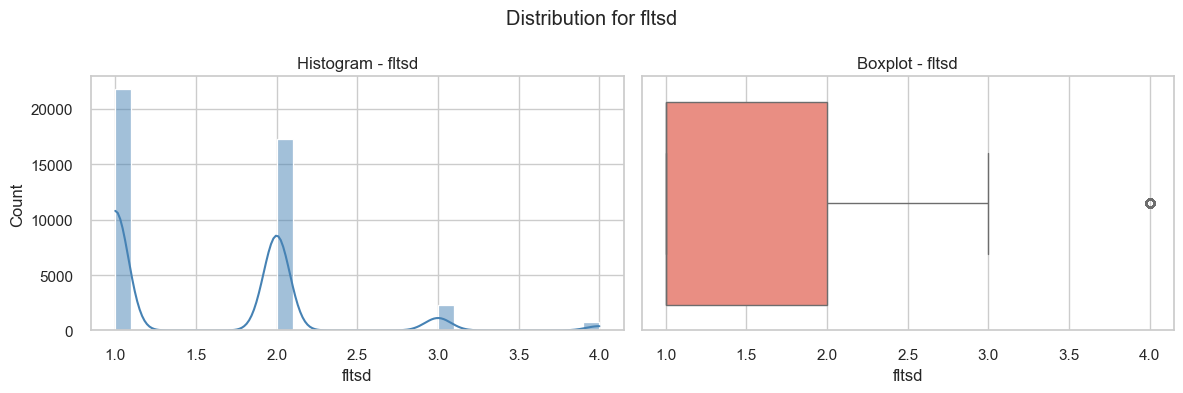

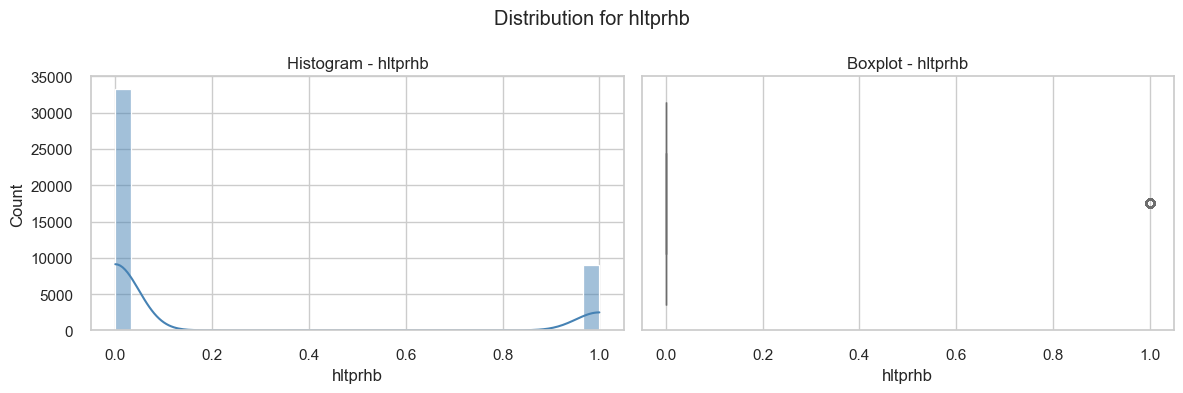

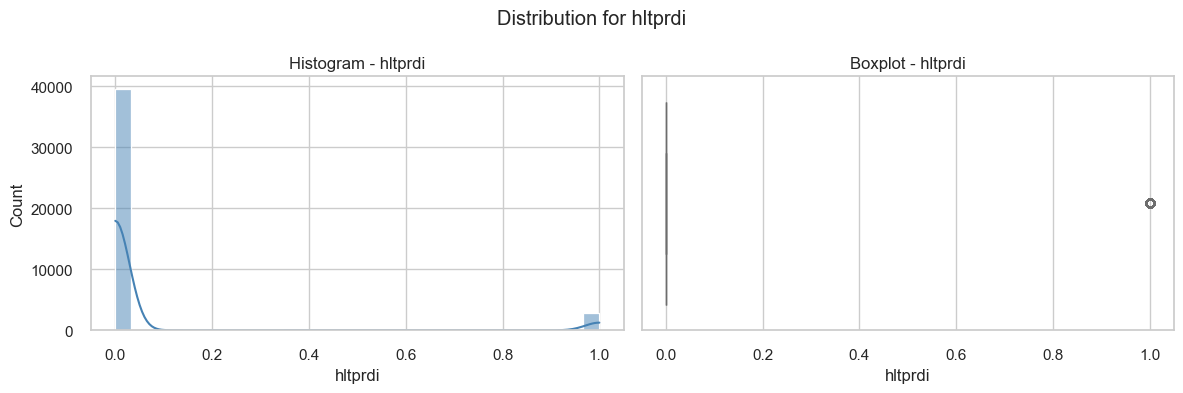

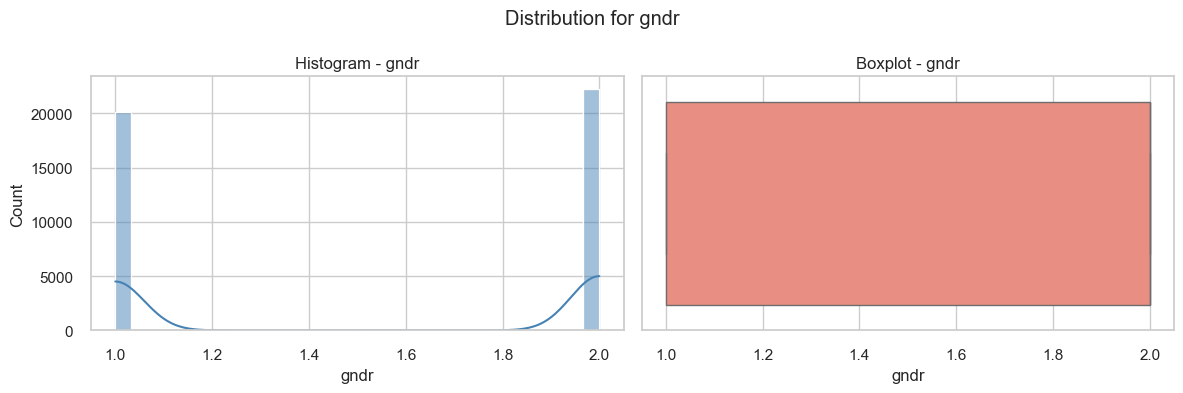

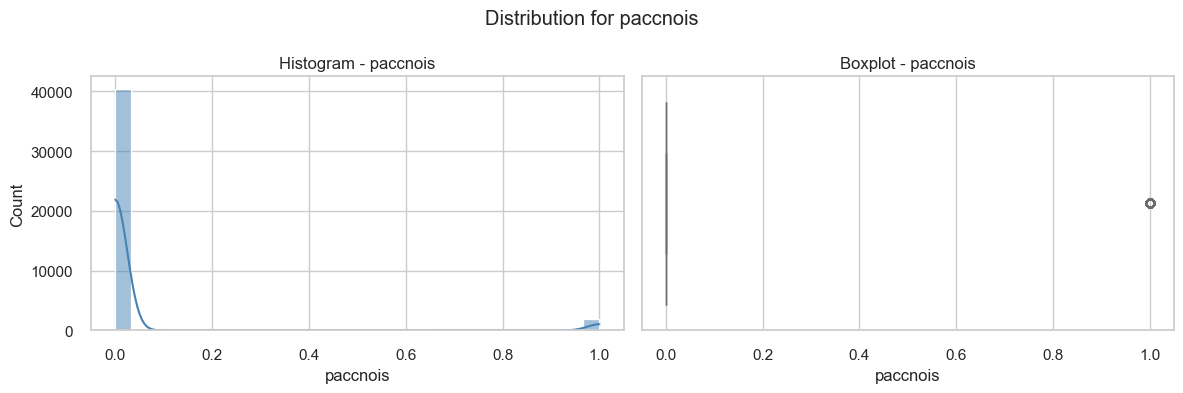

In [22]:

numeric_cols = df.drop(columns=[TARGET_COLUMN], errors='ignore').select_dtypes(include=[np.number]).columns.tolist()
print(f'Numeric features ({len(numeric_cols)}): {numeric_cols}')
for column in numeric_cols:
    series = df[column].dropna()
    if series.empty:
        continue
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(series, bins=30, kde=True, ax=axes[0], color='steelblue')
    axes[0].set_title(f'Histogram - {column}')
    axes[0].set_xlabel(column)
    sns.boxplot(x=series, ax=axes[1], color='salmon')
    axes[1].set_title(f'Boxplot - {column}')
    axes[1].set_xlabel(column)
    fig.suptitle(f'Distribution for {column}')
    fig.tight_layout()
    plot_path = PLOTS_DIR / f'{column}_distribution.png'
    fig.savefig(plot_path)
    plt.show()


### Categorical Variable Frequencies

Categorical features (1): ['cntry']


/var/folders/n7/xdcht4j57pb8lxj2cl5f_c500000gn/T/ipykernel_34628/2850643940.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette='viridis')


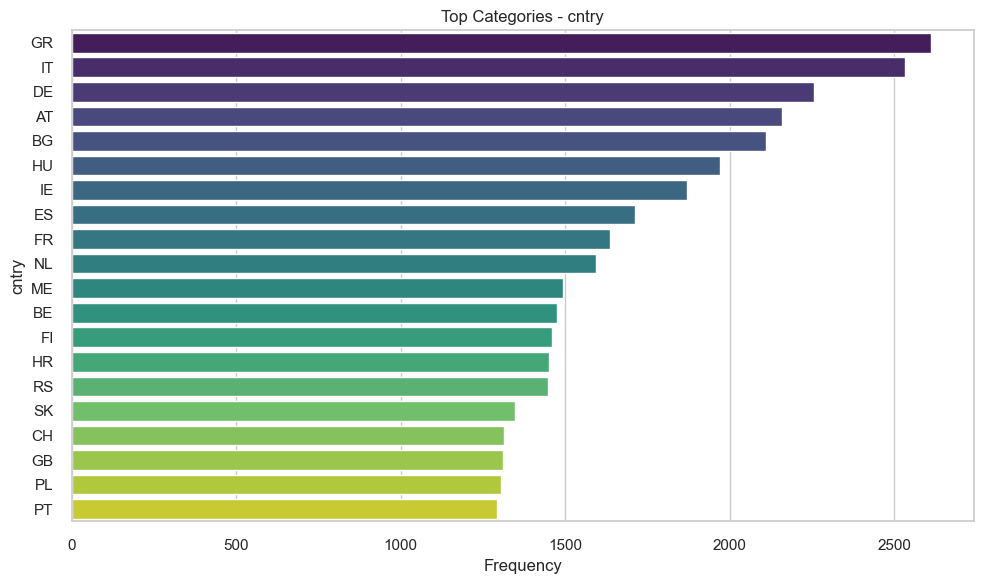

In [23]:

categorical_cols = df.drop(columns=[TARGET_COLUMN], errors='ignore').select_dtypes(exclude=[np.number]).columns.tolist()
print(f'Categorical features ({len(categorical_cols)}): {categorical_cols}')
if categorical_cols:
    for column in categorical_cols:
        counts = df[column].value_counts().head(20)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=counts.values, y=counts.index, palette='viridis')
        plt.title(f'Top Categories - {column}')
        plt.xlabel('Frequency')
        plt.ylabel(column)
        plot_path = PLOTS_DIR / f'{column}_frequency.png'
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.show()
else:
    print('No categorical variables detected.')


### Correlation Matrix and Heatmap

,happy,sclmeet,inprdsc,health,ctrlife,etfruit,eatveg,dosprt,cgtsmok,alcfreq,...,slprl,wrhpp,fltlnl,enjlf,fltsd,hltprhb,hltprdi,gndr,paccnois,hltprhc
happy,1.000000,0.225554,0.242421,-0.306482,0.438061,-0.106330,-0.129435,0.166759,0.106277,-0.084961,...,-0.210644,0.500393,-0.381547,0.464773,-0.382569,-0.085666,-0.065590,0.010270,-0.031871,-0.092729
sclmeet,0.225554,1.000000,0.268737,-0.176474,0.150259,-0.046354,-0.104672,0.170770,-0.000208,-0.155989,...,-0.097329,0.177207,-0.156745,0.198010,-0.149043,-0.091437,-0.047902,-0.027716,0.008578,-0.073038
inprdsc,0.242421,0.268737,1.000000,-0.150110,0.101998,-0.067486,-0.116240,0.171166,0.062441,-0.154980,...,-0.044406,0.192213,-0.190728,0.202873,-0.139019,-0.062421,-0.055158,0.013269,0.031447,-0.052643
health,-0.306482,-0.176474,-0.150110,1.000000,-0.200441,0.040737,0.076054,-0.188486,-0.030706,0.100089,...,0.284917,-0.279688,0.233368,-0.284118,0.267157,0.319389,0.233441,0.047569,0.053109,0.325057
ctrlife,0.438061,0.150259,0.101998,-0.200441,1.000000,-0.079329,-0.082001,0.135894,0.057447,-0.062569,...,-0.163326,0.285146,-0.232279,0.276283,-0.257903,-0.047673,-0.047408,-0.010253,-0.041415,-0.071057
etfruit,-0.106330,-0.046354,-0.067486,0.040737,-0.079329,1.000000,0.487831,-0.110279,-0.177591,-0.051944,...,0.039344,-0.076469,0.055722,-0.071122,0.035383,-0.005175,-0.013535,-0.125666,0.024357,-0.004205
eatveg,-0.129435,-0.104672,-0.116240,0.076054,-0.082001,0.487831,1.000000,-0.145028,-0.123710,0.019661,...,0.034651,-0.097334,0.087631,-0.103014,0.052099,0.031448,0.017519,-0.115543,-0.005601,0.027342
dosprt,0.166759,0.170770,0.171166,-0.188486,0.135894,-0.110279,-0.145028,1.000000,0.063007,-0.095671,...,-0.072252,0.160899,-0.132358,0.195155,-0.128983,-0.101122,-0.080486,-0.040751,0.008409,-0.088927
cgtsmok,0.106277,-0.000208,0.062441,-0.030706,0.057447,-0.177591,-0.123710,0.063007,1.000000,0.176337,...,-0.028558,0.075244,-0.044776,0.059356,-0.045252,0.011502,0.011221,0.161777,-0.013249,0.015419
alcfreq,-0.084961,-0.155989,-0.154980,0.100089,-0.062569,-0.051944,0.019661,-0.095671,0.176337,1.000000,...,0.053630,-0.052294,0.120835,-0.096038,0.117843,0.009772,0.054528,0.280693,-0.008419,0.047416


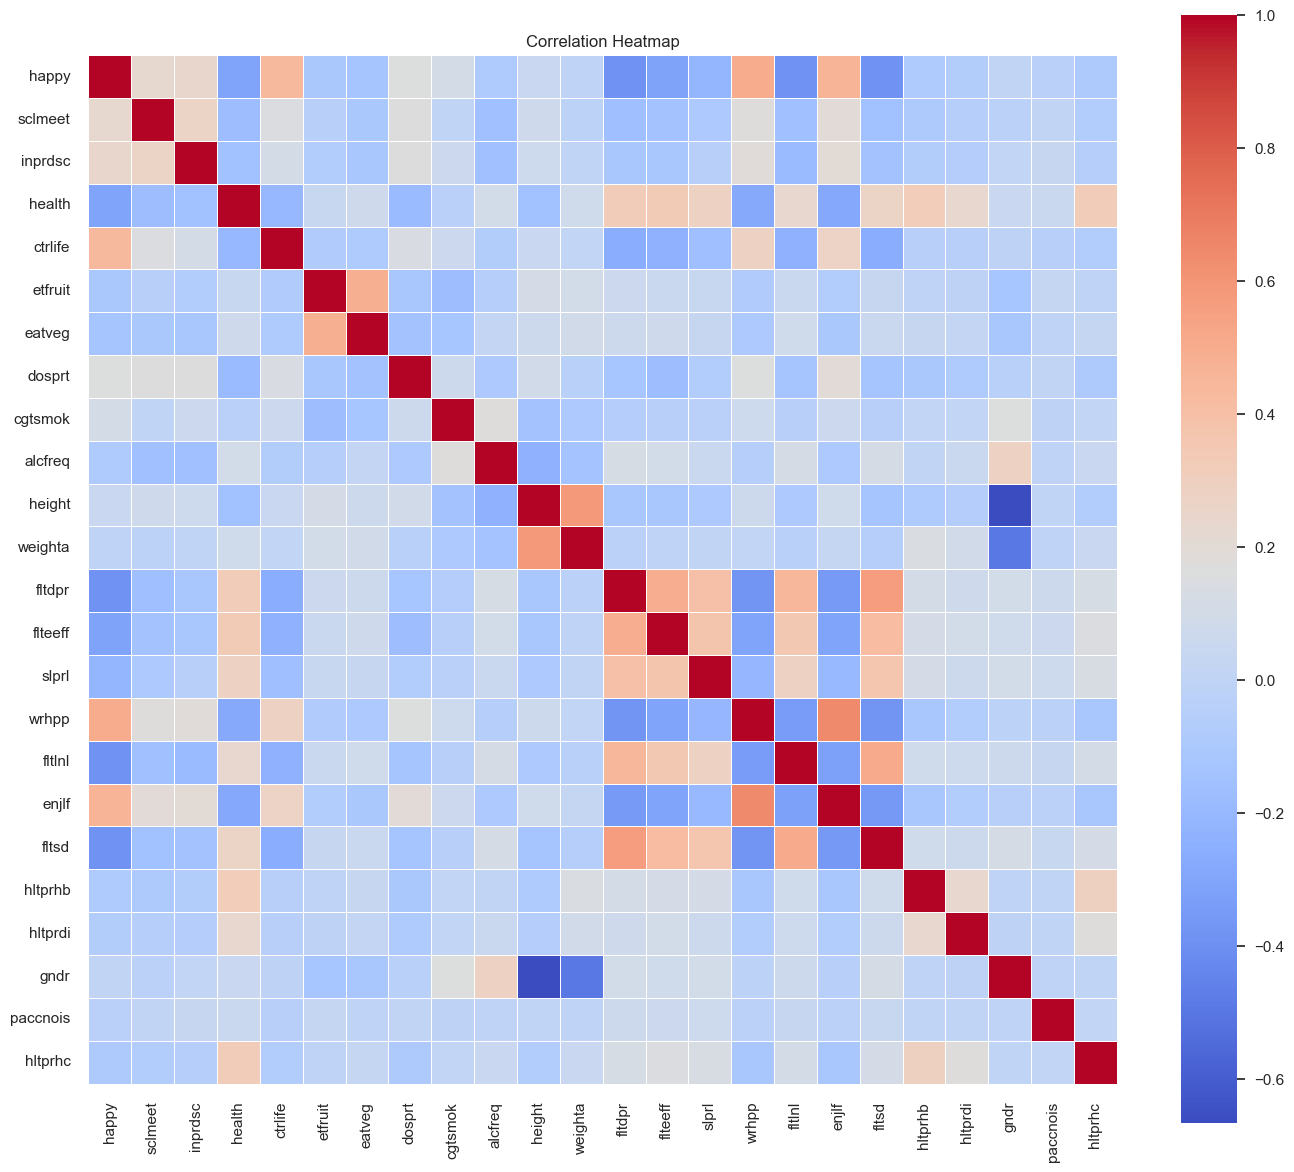

,correlation_with_target
health,0.325057
hltprhb,0.296244
hltprdi,0.174420
flteeff,0.151565
slprl,0.132750
fltdpr,0.124435
fltsd,0.111203
enjlf,-0.108051
wrhpp,-0.107986
fltlnl,0.107054


In [24]:

import pandas as pd  # reaffirm for clarity when re-running cells individually
target_corr = pd.Series(dtype=float)
if numeric_cols:
    corr = df[numeric_cols + [TARGET_COLUMN]].corr()
    display(corr)
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr, cmap='coolwarm', linewidths=0.5, square=True)
    plt.title('Correlation Heatmap')
    corr_path = PLOTS_DIR / 'correlation_heatmap.png'
    plt.tight_layout()
    plt.savefig(corr_path)
    plt.show()
    target_corr = corr[TARGET_COLUMN].drop(labels=[TARGET_COLUMN]).sort_values(key=lambda s: s.abs(), ascending=False)
    display(pd.DataFrame({'correlation_with_target': target_corr}))
else:
    print('Correlation matrix requires numeric features.')


### Multicollinearity Check (VIF)
Variance Inflation Factor (VIF) quantifies how much variance inflation each numeric feature experiences due to correlation with other predictors. Values above ~5–10 often signal multicollinearity worth addressing in downstream modelling.

In [25]:

def compute_vif(dataframe):
    if dataframe.shape[1] < 2:
        return pd.DataFrame()
    imputer = SimpleImputer(strategy='median')
    numeric_imputed = pd.DataFrame(
        imputer.fit_transform(dataframe), columns=dataframe.columns
    )
    vif_records = []
    for column in numeric_imputed.columns:
        y = numeric_imputed[column]
        X = numeric_imputed.drop(columns=[column])
        if X.empty:
            vif = np.nan
        else:
            model = LinearRegression()
            model.fit(X, y)
            r_squared = model.score(X, y)
            vif = np.inf if r_squared >= 1 else 1.0 / max(1 - r_squared, 1e-6)
        vif_records.append({'feature': column, 'vif': round(float(vif), 3)})
    return pd.DataFrame(vif_records)

vif_df = compute_vif(df[numeric_cols]) if numeric_cols else pd.DataFrame()
if not vif_df.empty:
    display(vif_df)
    vif_df.to_csv(METRICS_DIR / 'vif_summary.csv', index=False)
else:
    print('Not enough numeric features to compute VIF.')


,feature,vif
0,happy,1.735
1,sclmeet,1.159
2,inprdsc,1.179
3,health,1.443
4,ctrlife,1.274
5,etfruit,1.354
6,eatveg,1.356
7,dosprt,1.126
8,cgtsmok,1.098
9,alcfreq,1.179


### Findings:

low VIF (close to 1), indicating no severe multicollinearity issues.

VIF < 5 is generally acceptable.

VIF > 10 indicates serious multicollinearity.

None of the features indicates serious multicollinearity.

In [26]:
# Assess class balance for the target variable
from collections import Counter

class_counts_raw = Counter(df['hltprhc'].astype(int))
total_samples = sum(class_counts_raw.values())
for cls, count in class_counts_raw.items():
    pct = count / total_samples * 100
    print(f"Class {cls}: {count} samples ({pct:.2f}%)")

if len(class_counts_raw) == 2:
    min_pct = min(count / total_samples for count in class_counts_raw.values())
    max_pct = max(count / total_samples for count in class_counts_raw.values())
    if max_pct / min_pct > 1.5:
        print("Dataset is imbalanced; recall-focused metrics should be monitored during modelling.")
    else:
        print("Class distribution is relatively balanced.")
else:
    print("Target column contains unexpected number of classes.")

Class 0: 37582 samples (88.68%)
Class 1: 4795 samples (11.32%)
Dataset is imbalanced; recall-focused metrics should be monitored during modelling.


### Outlier Summary (IQR Method)

In [27]:

iqr_records = []
for column in numeric_cols:
    series = df[column].dropna()
    if series.empty:
        continue
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_mask = (series < lower) | (series > upper)
    iqr_records.append({
        'feature': column,
        'iqr': round(iqr, 3),
        'lower_bound': round(lower, 3),
        'upper_bound': round(upper, 3),
        'outlier_count': int(outlier_mask.sum()),
        'outlier_pct': round(outlier_mask.mean() * 100, 2),
    })

iqr_df = pd.DataFrame(iqr_records)
if not iqr_df.empty:
    display(iqr_df)
    iqr_df.to_csv(METRICS_DIR / 'outlier_summary_notebook.csv', index=False)
else:
    print('No numeric features available for IQR-based outlier detection.')


,feature,iqr,lower_bound,upper_bound,outlier_count,outlier_pct
0,happy,2.0,4.0,12.0,1620,3.83
1,sclmeet,2.0,1.0,9.0,0,0.00
2,inprdsc,2.0,-1.0,7.0,0,0.00
3,health,2.0,-2.0,6.0,0,0.00
4,ctrlife,3.0,1.5,13.5,478,1.13
5,etfruit,2.0,-1.0,7.0,0,0.00
6,eatveg,2.0,-1.0,7.0,0,0.00
7,dosprt,5.0,-7.5,12.5,0,0.00
8,cgtsmok,3.0,-1.5,10.5,0,0.00
9,alcfreq,4.0,-3.0,13.0,0,0.00


### EDA Summary Table

In [28]:

overall_missing_pct = round((df.isna().sum().sum() / (row_count * col_count)) * 100, 2)
class_balance_summary = '; '.join([f"{int(cls)}: {pct}%" for cls, pct in target_pct.items()])
top_corr_summary = ''
if not target_corr.empty:
    top_corr_summary = '; '.join([f"{idx + 1}. {feature} ({value:.3f})" for idx, (feature, value) in enumerate(target_corr.head(3).items())])
eda_summary = pd.DataFrame([
    {'metric': 'row_count', 'value': row_count},
    {'metric': 'column_count', 'value': col_count},
    {'metric': 'overall_missing_pct', 'value': overall_missing_pct},
    {'metric': 'class_balance', 'value': class_balance_summary},
])
if top_corr_summary:
    eda_summary = pd.concat([eda_summary, pd.DataFrame([{'metric': 'top_correlations', 'value': top_corr_summary}])], ignore_index=True)
display(eda_summary)
eda_summary.to_csv(METRICS_DIR / 'eda_summary.csv', index=False)


,metric,value
0,row_count,42377
1,column_count,25
2,overall_missing_pct,0.26
3,class_balance,0: 88.68%; 1: 11.32%
4,top_correlations,1. health (0.325); 2. hltprhb (0.296); 3. hltp...


### Summary of EDA Findings

### Summary of EDA Findings (Raw Dataset)
- Dataset contains **42,377** rows and **25** columns (after dropping the unnamed index column). Only `cntry` remains categorical; all other fields are numeric survey responses (including the targets).
- Overall missingness is **0.25%**. Highest missing rates appear in lifestyle/behaviour questions such as `dosprt` (1.06%), `enjlf` (0.62%), `wrhpp` (0.55%), `inprdsc` (0.49%), and `alcfreq` (0.46%).
- Target variable `hltprhc` is imbalanced: **11.32%** of respondents report a diagnosed heart/circulation problem (class = 1) versus **88.68%** with class = 0.
- Most lifestyle frequency features (fruit/veg intake, sports participation) are right-skewed, indicating many respondents report low activity levels; histograms & boxplots capture these skews.
- Correlation heatmap shows only modest linear relationships with `hltprhc`; clinical history fields (`hltprhb`, `hltprdi`) provide the strongest signals, reinforcing the need for non-linear models and explainability overlays.
- IQR analysis flags minority clinical indicators (`hltprhb`, `hltprdi`, `hltprhc`) as outliers because positives are scarce; sleep/rest metrics (`slprl`) and perceived neighbourhood noise (`paccnois`) also show heavier tails worth monitoring during preprocessing.
- Outputs (missing-value table, distributions, heatmaps, VIF, and IQR summaries) are regenerated under `results/metrics/` and `results/plots/` for traceability.



### Processed Dataset Preview
- Feature names: see `data/processed/feature_names.csv`
- Rows × Columns: will mirror the raw count after filtering and encoding.
- Use `src.data_preprocessing.load_dataset(PROCESSED_PATH)` during modelling for the cleaned, encoded feature matrix.
